# Analyse des réseaux


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats


import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


import networkx as nx

from itables import init_notebook_mode, show


from netgraph import Graph, InteractiveGraph

from pyvis.network import Network

from fanalysis.ca import CA 
from fanalysis.mca import MCA
# Importation du fichier csv qui se trouve dans le même dossier que le notebook
data1 = pd.read_csv("CSV/analyse_personne_universite.csv")

In [4]:
len(data1)

4820

In [5]:
data1.head(2)

,fk_personne,nom,annee_nais,fk_uni,universite
0,http://www.wikidata.org/entity/Q6177457,Jeni Bojilova-Pateva,1878,http://www.wikidata.org/entity/Q12291455,"""Nancho Popovich"" Natural Sciences High School"
1,http://www.wikidata.org/entity/Q16063667,Elisabeth Møller Jensen,1946,http://www.wikidata.org/entity/Q924265,Aarhus University


In [6]:
### Ajouter deux périodes différentes en fonctions de la relation
# Pour la relation 'étudier' créer une période entre 18 et 28 ans (+17, +27) pour l'étendue des études
# Pour la relation 'insitution' ajouté une période d'activité de 19 à 65 ans
data1['YBegin'] = data1[['annee_nais']].apply(lambda x : int(x['annee_nais'] + 17), axis=1)
data1['YEnd'] = data1[['annee_nais']].apply(lambda x : int(x['annee_nais'] + 27), axis=1)


In [7]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4820 entries, 0 to 4819
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   fk_personne  4820 non-null   object
 1   nom          4820 non-null   object
 2   annee_nais   4820 non-null   int64 
 3   fk_uni       4820 non-null   object
 4   universite   4820 non-null   object
 5   YBegin       4820 non-null   int64 
 6   YEnd         4820 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 263.7+ KB


In [8]:
### Inspecter la distribution des années de naissance
data1.annee_nais.describe()

count    4820.000000
mean     1949.594191
std        32.153057
min      1818.000000
25%      1936.000000
50%      1954.000000
75%      1972.000000
max      1999.000000
Name: annee_nais, dtype: float64

In [9]:
show(data1[[ 'fk_personne','nom','fk_uni','universite','YBegin','YEnd','annee_nais']].sort_values(by='annee_nais'), classes="display", scrollY="200px", 
     scrollCollapse=True, paging=False, column_filters="footer", dom="lrtip")

# Commentaire
**il faut peut-être que je nettoye mes données à voir ce que les graphes me donnent**

In [10]:
organisations = data1.groupby(by='universite').size()
show(organisations.sort_index(ascending=False))

In [11]:
s = data1.annee_nais

(1818.0, 1999.0)

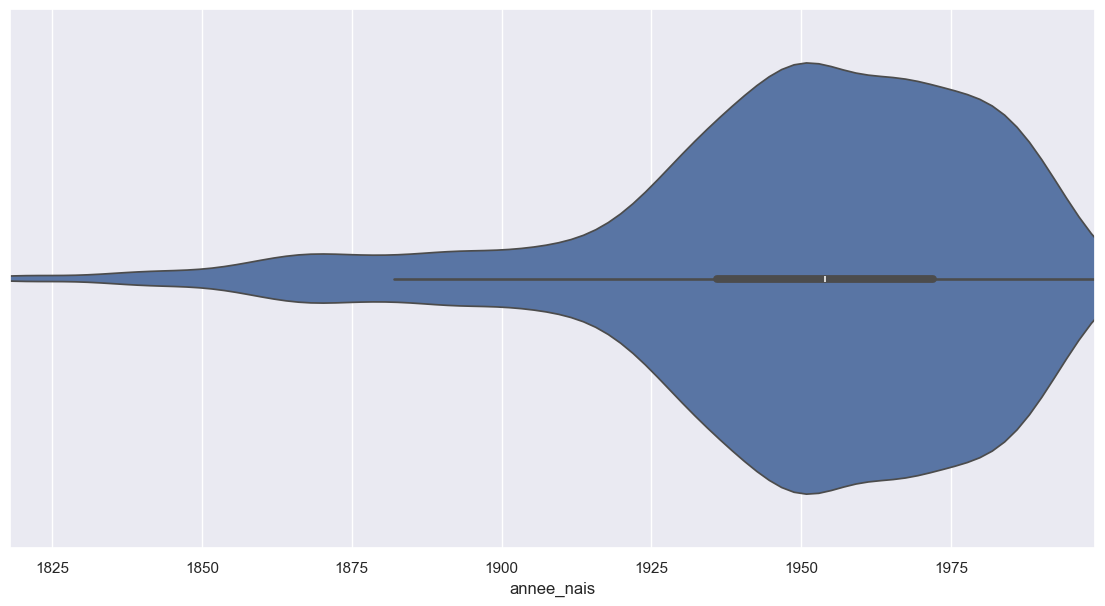

In [12]:
### Violinplot : densité des naissances dans le temps
#  https://mode.com/blog/violin-plot-examples/
#  https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

sns.set_theme(style="whitegrid")

sns.set(rc={"figure.figsize":(14, 7)})

### Personnes nées avant 1931 (protection des données)
# a = s[(s<1931)] 
## Période pré-scientifique
## Décollage de la science 'moderne'
a = s[(s>1800) & (s<2000)] # 
## Science contemporaine
# a = s[(s>1900) ] # 
lim_left=min(a)
lim_right=max(a)





ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=lim_left, right=lim_right)

## Période et dictionnaires

In [13]:
bins=[1801,1851,1901,1951, 2000]

In [14]:
data1['periode'] = pd.cut(data1['annee_nais'], bins=bins, right=False  )
data1.periode = data1.periode.apply( lambda x : str(x.left) + '_' + str(x.right))

In [15]:
data1.head(2)

,fk_personne,nom,annee_nais,fk_uni,universite,YBegin,YEnd,periode
0,http://www.wikidata.org/entity/Q6177457,Jeni Bojilova-Pateva,1878,http://www.wikidata.org/entity/Q12291455,"""Nancho Popovich"" Natural Sciences High School",1895,1905,1851_1901
1,http://www.wikidata.org/entity/Q16063667,Elisabeth Møller Jensen,1946,http://www.wikidata.org/entity/Q924265,Aarhus University,1963,1973,1901_1951


In [16]:
### Effectif par période
data1.groupby(by='periode', observed= True).size()

periode
1801_1851      56
1851_1901     357
1901_1951    1730
1951_2000    2677
dtype: int64

In [17]:
ldf = data1[['fk_personne', 'nom','annee_nais', 'fk_uni', 'universite',
       'YBegin', 'YEnd', 'periode']].sort_values(by='nom').to_dict('records')

In [18]:
ldf[:2]

[{'fk_personne': 'http://www.wikidata.org/entity/Q4648092',
  'nom': 'A. Latham Staples',
  'annee_nais': 1977,
  'fk_uni': 'http://www.wikidata.org/entity/Q812573',
  'universite': 'Baylor University',
  'YBegin': 1994,
  'YEnd': 2004,
  'periode': '1951_2000'},
 {'fk_personne': 'http://www.wikidata.org/entity/Q119856937',
  'nom': 'ABilly S. Jones-Hennin',
  'annee_nais': 1942,
  'fk_uni': 'http://www.wikidata.org/entity/Q1068752',
  'universite': 'Howard University',
  'YBegin': 1959,
  'YEnd': 1969,
  'periode': '1901_1951'}]

## Graphe à deux types de sommets

Il s'agit d'un graphe de type 'bipartite'

In [21]:
l = []
for i in ldf:
    if i['periode'] == '1851_1901':
        l.append(tuple((i['nom'],i['universite'], 
                        {'relationship': i['fk_uni'], "annee_naiss": i['annee_nais'], "periode": i['periode'] })))
l[:5]

[('Abigail de Paiva Cruz',
  'Escola Superior de Belas-Artes do Porto',
  {'relationship': 'http://www.wikidata.org/entity/Q10274472',
   'annee_naiss': 1883,
   'periode': '1851_1901'}),
 ('Adelaide Casely-Hayford',
  'Jersey College for Girls',
  {'relationship': 'http://www.wikidata.org/entity/Q6184813',
   'annee_naiss': 1868,
   'periode': '1851_1901'}),
 ('Adelaide Casely-Hayford',
  'State University of Music and Performing Arts Stuttgart',
  {'relationship': 'http://www.wikidata.org/entity/Q568692',
   'annee_naiss': 1868,
   'periode': '1851_1901'}),
 ('Agnes Metcalfe',
  'University of London',
  {'relationship': 'http://www.wikidata.org/entity/Q170027',
   'annee_naiss': 1870,
   'periode': '1851_1901'}),
 ('Alda Heaton Wilson',
  'Iowa State University',
  {'relationship': 'http://www.wikidata.org/entity/Q1136919',
   'annee_naiss': 1873,
   'periode': '1851_1901'})]

In [22]:
# Graphe Personne- Organisation
POG=nx.Graph()

In [23]:
POG.add_edges_from(l)

In [24]:
### Créer une liste des organisations
l_org = list(organisations.index); len(l_org); l_org[:3]

['"Nancho Popovich" Natural Sciences High School',
 'Aarhus University',
 'Abat Oliba CEU University']

In [25]:
list(POG.nodes.data())[:4]

[('Abigail de Paiva Cruz', {}),
 ('Escola Superior de Belas-Artes do Porto', {}),
 ('Adelaide Casely-Hayford', {}),
 ('Jersey College for Girls', {})]

In [26]:
### Ajouter au sommets un code si personne ou organisation
# On utiliser pour ce faire la liste des organisations
types = {}
for e in list(POG.nodes):
    if e in l_org:
        t = 'O'
    else:
        t = 'P'
    types[e] = {'type': t} 
[(k,v )for k,v in types.items()][:3]  

[('Abigail de Paiva Cruz', {'type': 'P'}),
 ('Escola Superior de Belas-Artes do Porto', {'type': 'O'}),
 ('Adelaide Casely-Hayford', {'type': 'P'})]

In [27]:
nx.set_node_attributes(POG, types)
list(POG.nodes.data())[:3]

[('Abigail de Paiva Cruz', {'type': 'P'}),
 ('Escola Superior de Belas-Artes do Porto', {'type': 'O'}),
 ('Adelaide Casely-Hayford', {'type': 'P'})]

In [118]:
### Ajouter la centralité de degré
# grâce à un dictionnaire construit selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(POG)])

In [119]:
nx.set_node_attributes(POG, degree)


In [120]:
print(list(POG.nodes.data())[:4])

[('Abigail de Paiva Cruz', {'type': 'P', 'degree': 1}), ('Escola Superior de Belas-Artes do Porto', {'type': 'O', 'degree': 1}), ('Adelaide Casely-Hayford', {'type': 'P', 'degree': 2}), ('Jersey College for Girls', {'type': 'O', 'degree': 1})]


In [121]:
persons_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'P':
        persons_degree.append([n[0], n[1]['degree']])

In [122]:
sorted(persons_degree, key = lambda x : x[1], reverse=True)[:10]

[['Alice Paul', 6],
 ['Magnus Hirschfeld', 6],
 ['W. E. B. Du Bois', 6],
 ['Bhimrao Ramji Ambedkar', 5],
 ['Sen Katayama', 5],
 ['Sylvia Pankhurst', 4],
 ['Zeng Baosun', 4],
 ['Alexis Nour', 3],
 ['Amelia Earhart', 3],
 ['Beatrice Harraden', 3]]

In [123]:
org_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'O':
        org_degree.append([n[0], n[1]['degree']])

In [124]:
sorted(org_degree, key = lambda x : x[1], reverse=True)[:10]

[['University of Zurich', 7],
 ['Columbia University', 7],
 ['University of Paris', 7],
 ['Free University of Brussels', 7],
 ['Uppsala University', 6],
 ['University of Chicago', 6],
 ['Alexandru Ioan Cuza University', 5],
 ['University of Oslo', 5],
 ['Heidelberg University', 5],
 ['University of Copenhagen', 5]]

In [125]:
edges = list(POG.edges.data())
edges[:5]

[('Abigail de Paiva Cruz',
  'Escola Superior de Belas-Artes do Porto',
  {'relationship': 'http://www.wikidata.org/entity/Q10274472',
   'annee_naiss': 1883,
   'periode': '1850_1900'}),
 ('Adelaide Casely-Hayford',
  'Jersey College for Girls',
  {'relationship': 'http://www.wikidata.org/entity/Q6184813',
   'annee_naiss': 1868,
   'periode': '1850_1900'}),
 ('Adelaide Casely-Hayford',
  'State University of Music and Performing Arts Stuttgart',
  {'relationship': 'http://www.wikidata.org/entity/Q568692',
   'annee_naiss': 1868,
   'periode': '1850_1900'}),
 ('Agnes Metcalfe',
  'University of London',
  {'relationship': 'http://www.wikidata.org/entity/Q170027',
   'annee_naiss': 1870,
   'periode': '1850_1900'}),
 ('University of London',
  'Emily Davison',
  {'relationship': 'http://www.wikidata.org/entity/Q170027',
   'annee_naiss': 1872,
   'periode': '1850_1900'})]

In [126]:
labels = {}    
for node in POG.nodes():
    labels[node] = node

In [127]:
nx.set_node_attributes(POG, labels, 'label')

In [1]:
nodes = list(POG.nodes.data())
nodes[:5]

NameError: name 'POG' is not defined

### Analyse du Graphe

In [129]:
components = nx.connected_components(POG);
components_l = [len(c) for c in sorted(nx.connected_components(POG), key=len, reverse=True)]
len(components_l), components_l[:5]

(118, [50, 43, 40, 14, 12])

In [130]:
S = [POG.subgraph(c).copy() for c in nx.connected_components(POG)]

In [131]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[6, 50], [2, 43], [11, 40], [7, 14], [26, 12], [8, 9], [33, 9], [38, 9]]

In [132]:
li=[n[0] for n in ln]

In [133]:
S[21].nodes 

NodeView(('Académie de la Grande Chaumière', 'Augusta Savage', 'Cooper Union'))

### Représenter le graphe

In [134]:
u = S[14]

In [135]:
u = nx.Graph()
for i in li[:5]:
    u = nx.union(u, S[i])
type(u) 

networkx.classes.graph.Graph

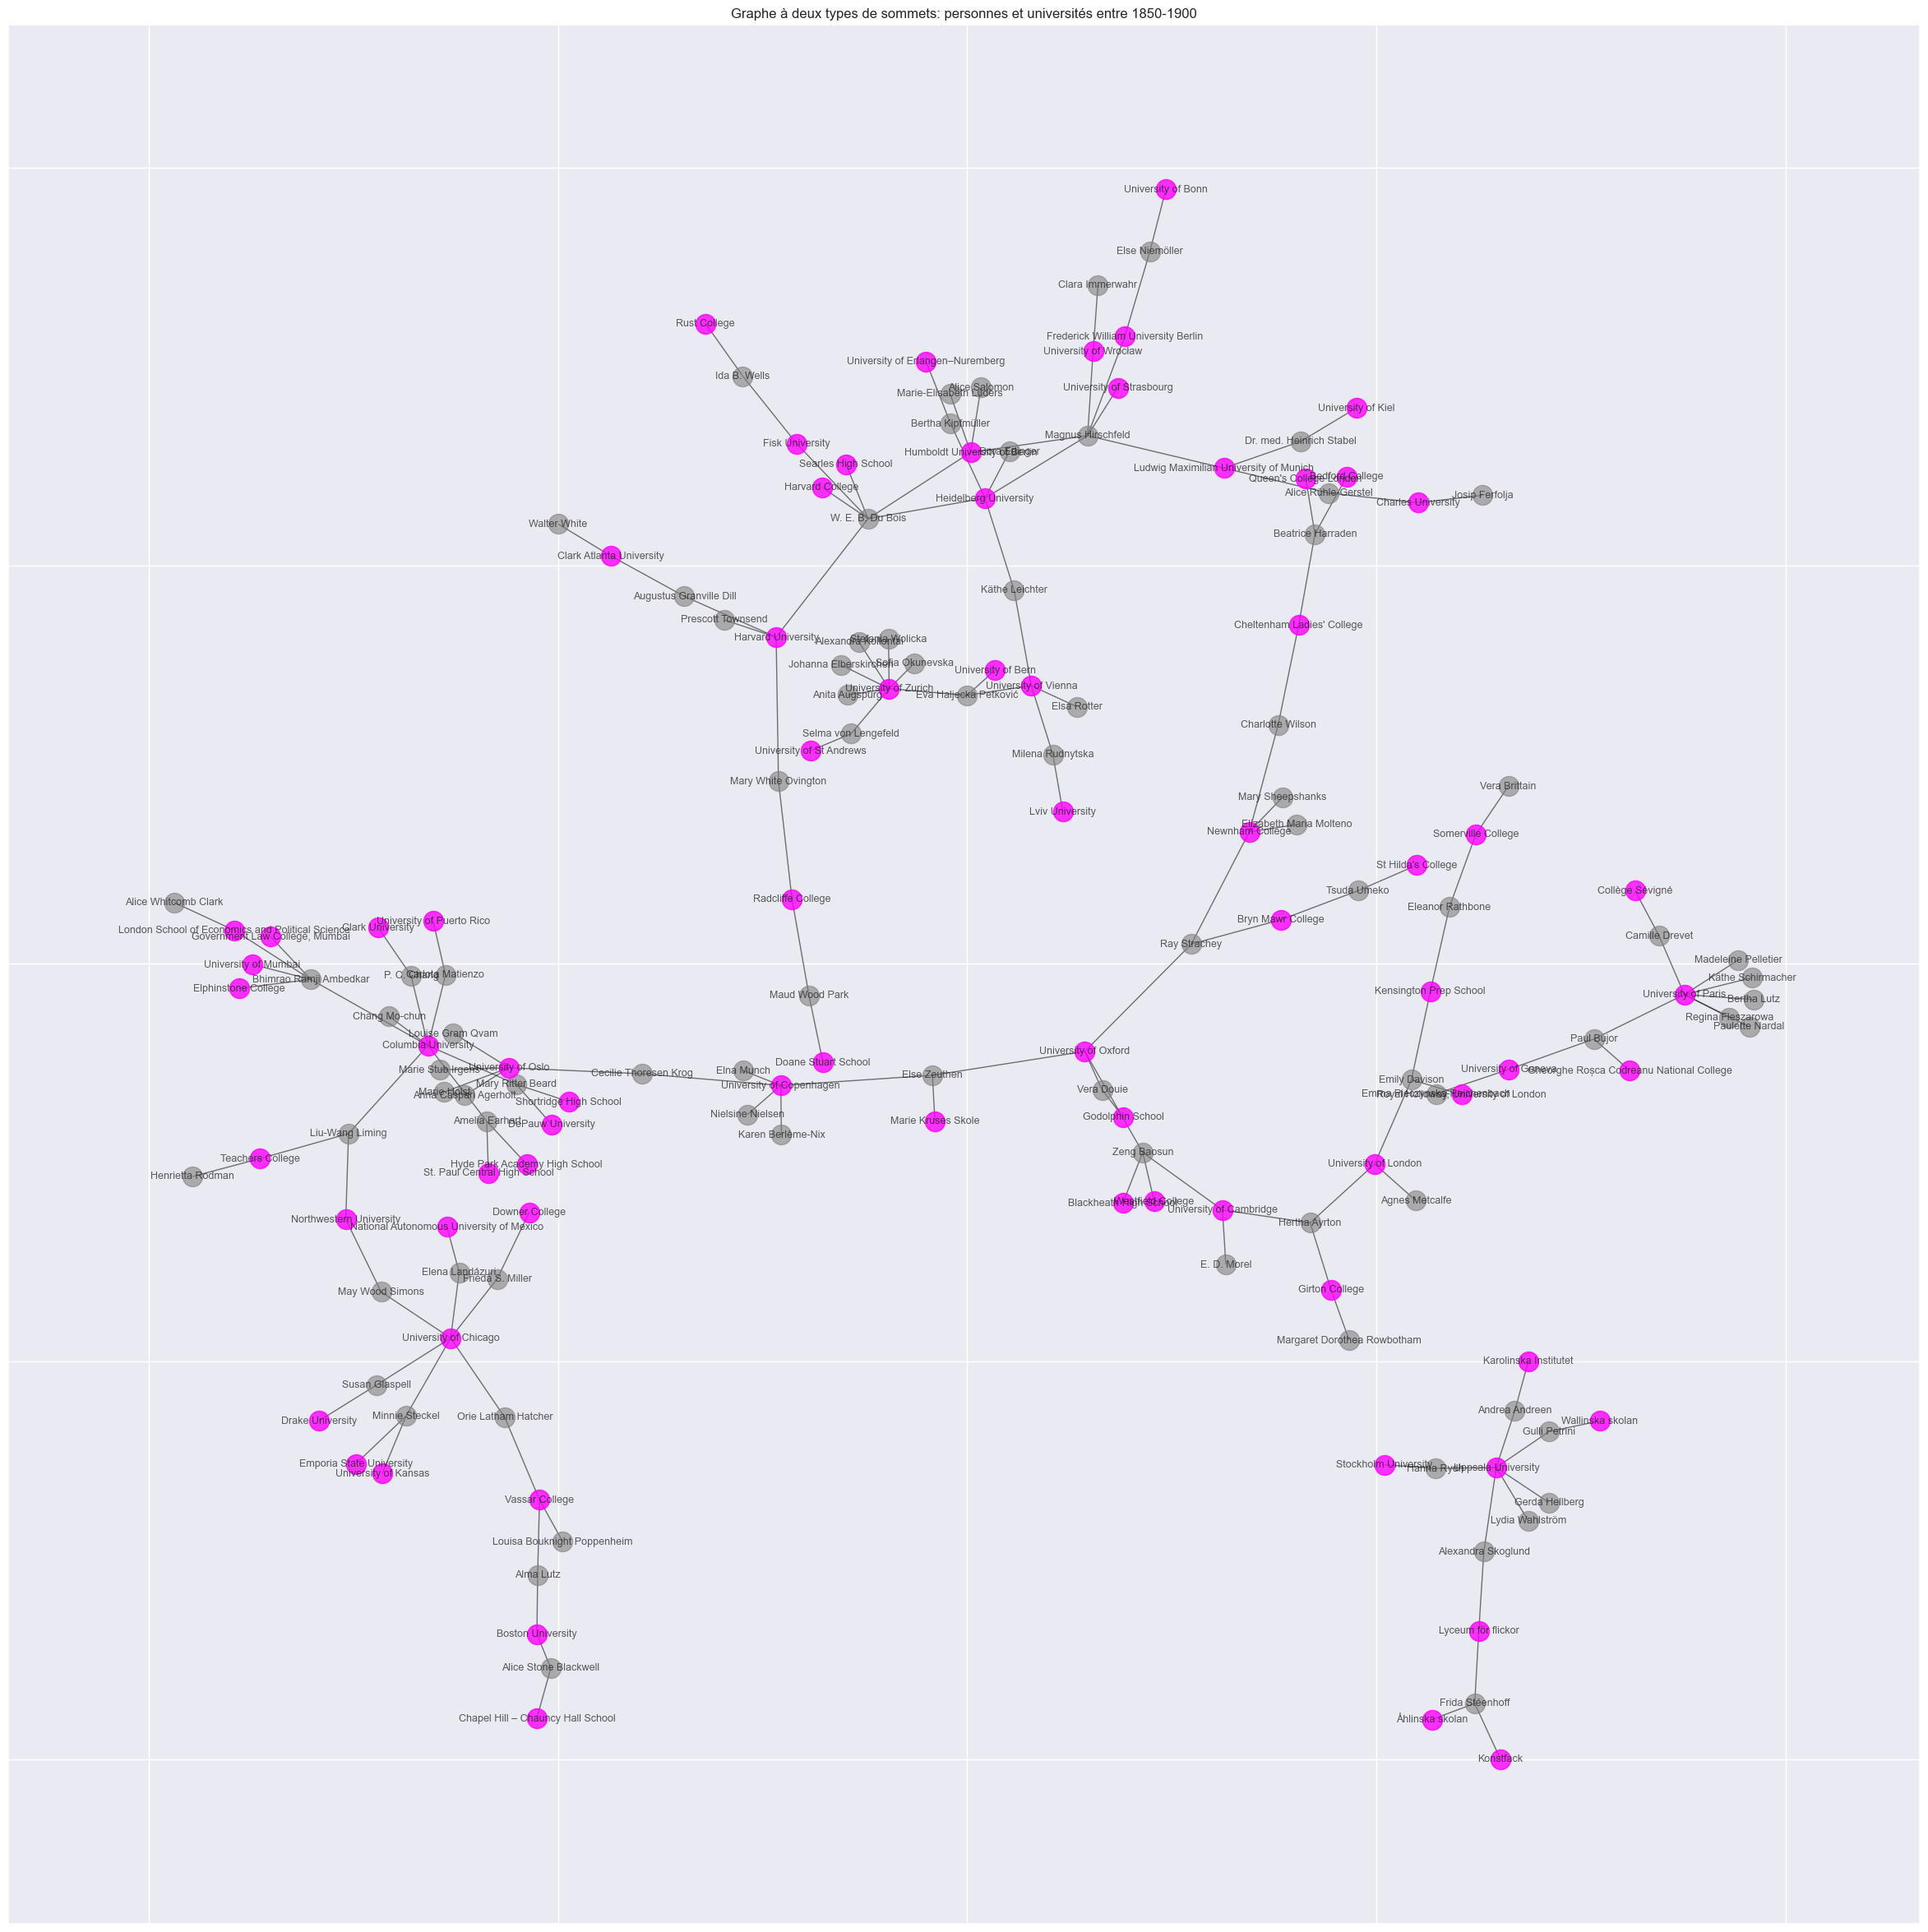

In [136]:
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)

no = [x for x,y in g.nodes(data=True) if y['type']=='O']
np = [x for x,y in g.nodes(data=True) if y['type']=='P'] 

co = 'fuchsia'
cp = 'grey'
nx.draw_networkx_nodes(g, pos, nodelist=np, node_color=cp, alpha=0.6)
nx.draw_networkx_nodes(g, pos, nodelist=no, node_color=co, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=9)
plt.title('Graphe à deux types de sommets: personnes et universités entre 1850-1900')
plt.show()

**Graphe pour 1900_1950** est beaucoup plus fourni que celui de la seconde moitié du 19ème 

## Création de relation entre les personnes
* Tester le lien entre l'université et période

In [48]:
### Pairs de personnes
pairs_p = []

for s1 in ldf:
    for s2 in ldf:
        if s1['nom'] < s2['nom'] \
            and s1['universite'] == s2['universite'] \
            and s2['YEnd'] > s1['YBegin'] \
            and s2['YBegin'] < s1['YEnd']:
            pairs_p.append([s1,s2])
        else:
            pass

In [49]:
len(pairs_p)

3934

In [50]:
pairs_p[:1]

[[{'fk_personne': 'http://www.wikidata.org/entity/Q119856937',
   'nom': 'ABilly S. Jones-Hennin',
   'annee_nais': 1942,
   'fk_uni': 'http://www.wikidata.org/entity/Q1068752',
   'universite': 'Howard University',
   'YBegin': 1959,
   'YEnd': 1969,
   'periode': '1900_1950'},
  {'fk_personne': 'http://www.wikidata.org/entity/Q5271535',
   'nom': 'Diane Nash',
   'annee_nais': 1938,
   'fk_uni': 'http://www.wikidata.org/entity/Q1068752',
   'universite': 'Howard University',
   'YBegin': 1955,
   'YEnd': 1965,
   'periode': '1900_1950'}]]

## Pairs d'organisation

In [51]:
## Pairs d'organisations
pairs_o = []

for s1 in ldf:
    for s2 in ldf:
        if s1['universite'] < s2['universite'] \
            and s1['nom'] == s2['nom']:
                pairs_o.append([s1,s2])
        else:
            pass

In [52]:
len(pairs_o)

2876

In [53]:
### Apparaissent des parcours de vie
pairs_o[:1]

[[{'fk_personne': 'http://www.wikidata.org/entity/Q119856937',
   'nom': 'ABilly S. Jones-Hennin',
   'annee_nais': 1942,
   'fk_uni': 'http://www.wikidata.org/entity/Q1068752',
   'universite': 'Howard University',
   'YBegin': 1959,
   'YEnd': 1969,
   'periode': '1900_1950'},
  {'fk_personne': 'http://www.wikidata.org/entity/Q119856937',
   'nom': 'ABilly S. Jones-Hennin',
   'annee_nais': 1942,
   'fk_uni': 'http://www.wikidata.org/entity/Q7934591',
   'universite': 'Virginia State University',
   'YBegin': 1959,
   'YEnd': 1969,
   'periode': '1900_1950'}]]

## Personnes (filtres, sous populations)
on va commencer par la période que le graphe d'avant 1850-1900

In [67]:
prem_20_pairs = [p for p in pairs_p if ((p[0]['periode']=='1850_1900') & (p[1]['periode']=='1850_1900'))]

In [68]:
len(prem_20_pairs), prem_20_pairs[:3]

(109,
 [[{'fk_personne': 'http://www.wikidata.org/entity/Q96052486',
    'nom': 'Agnes Metcalfe',
    'annee_nais': 1870,
    'fk_uni': 'http://www.wikidata.org/entity/Q170027',
    'universite': 'University of London',
    'YBegin': 1887,
    'YEnd': 1897,
    'periode': '1850_1900'},
   {'fk_personne': 'http://www.wikidata.org/entity/Q254858',
    'nom': 'Emily Davison',
    'annee_nais': 1872,
    'fk_uni': 'http://www.wikidata.org/entity/Q170027',
    'universite': 'University of London',
    'YBegin': 1889,
    'YEnd': 1899,
    'periode': '1850_1900'}],
  [{'fk_personne': 'http://www.wikidata.org/entity/Q179558',
    'nom': 'Alexandra Kollontai',
    'annee_nais': 1872,
    'fk_uni': 'http://www.wikidata.org/entity/Q206702',
    'universite': 'University of Zurich',
    'YBegin': 1889,
    'YEnd': 1899,
    'periode': '1850_1900'},
   {'fk_personne': 'http://www.wikidata.org/entity/Q60568721',
    'nom': 'Eva Haljecka Petković',
    'annee_nais': 1870,
    'fk_uni': 'http://www.w

## Exploration graphe personnes

In [69]:
l = []
for i in prem_20_pairs: #almaMater_pairs:
    l.append(tuple((i[0]['nom'],i[1]['nom'], {'relationship': f"{i[0]['universite']}_{i[1]['universite']}", 
                                                              'organisation': i[0]['universite'] })))
l[:5]

[('Agnes Metcalfe',
  'Emily Davison',
  {'relationship': 'University of London_University of London',
   'organisation': 'University of London'}),
 ('Alexandra Kollontai',
  'Eva Haljecka Petković',
  {'relationship': 'University of Zurich_University of Zurich',
   'organisation': 'University of Zurich'}),
 ('Alexandra Kollontai',
  'Johanna Elberskirchen',
  {'relationship': 'University of Zurich_University of Zurich',
   'organisation': 'University of Zurich'}),
 ('Alexandra Kollontai',
  'Selma von Lengefeld',
  {'relationship': 'University of Zurich_University of Zurich',
   'organisation': 'University of Zurich'}),
 ('Alexandra Kollontai',
  'Sofia Okunevska',
  {'relationship': 'University of Zurich_University of Zurich',
   'organisation': 'University of Zurich'})]

In [70]:
EMP=nx.Graph()
EMP.add_edges_from(l)
nodes = list(EMP.nodes.data())
nodes[:5]

[('Agnes Metcalfe', {}),
 ('Emily Davison', {}),
 ('Alexandra Kollontai', {}),
 ('Eva Haljecka Petković', {}),
 ('Johanna Elberskirchen', {})]

In [71]:
edges = list(EMP.edges.data())
edges[:5]

[('Agnes Metcalfe',
  'Emily Davison',
  {'relationship': 'University of London_University of London',
   'organisation': 'University of London'}),
 ('Emily Davison',
  'Eleanor Rathbone',
  {'relationship': 'Kensington Prep School_Kensington Prep School',
   'organisation': 'Kensington Prep School'}),
 ('Alexandra Kollontai',
  'Eva Haljecka Petković',
  {'relationship': 'University of Zurich_University of Zurich',
   'organisation': 'University of Zurich'}),
 ('Alexandra Kollontai',
  'Johanna Elberskirchen',
  {'relationship': 'University of Zurich_University of Zurich',
   'organisation': 'University of Zurich'}),
 ('Alexandra Kollontai',
  'Selma von Lengefeld',
  {'relationship': 'University of Zurich_University of Zurich',
   'organisation': 'University of Zurich'})]

In [72]:
labels = {}    
for node in EMP.nodes():
    labels[node] = node

## Analyser les composantes du graphe

In [73]:
nx.is_connected(EMP)

False

In [75]:
components = nx.connected_components(EMP);
components_l = [len(c) for c in sorted(nx.connected_components(EMP), key=len, reverse=True)]
len(components_l), components_l[:5]
# Résultat: 25 composantes

(25, [9, 8, 8, 7, 5])

In [76]:
S = [EMP.subgraph(c).copy() for c in nx.connected_components(EMP)]
# S = liste des sous-graphes

In [77]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]
# résultat le plus volumineux


[[4, 9], [1, 8], [10, 8], [5, 7], [2, 5], [3, 5], [9, 4], [11, 4]]

In [78]:
li=[n[0] for n in ln]

In [79]:
## type de graphe
u = nx.Graph()
for i in li[0:4]:
    u = nx.union(u, S[i])
type(u) 
# ici FILTRE POUR CHOISIR LES GRAPHES !!!!! FAUT ESSAYER

networkx.classes.graph.Graph

In [80]:
u = S[5]

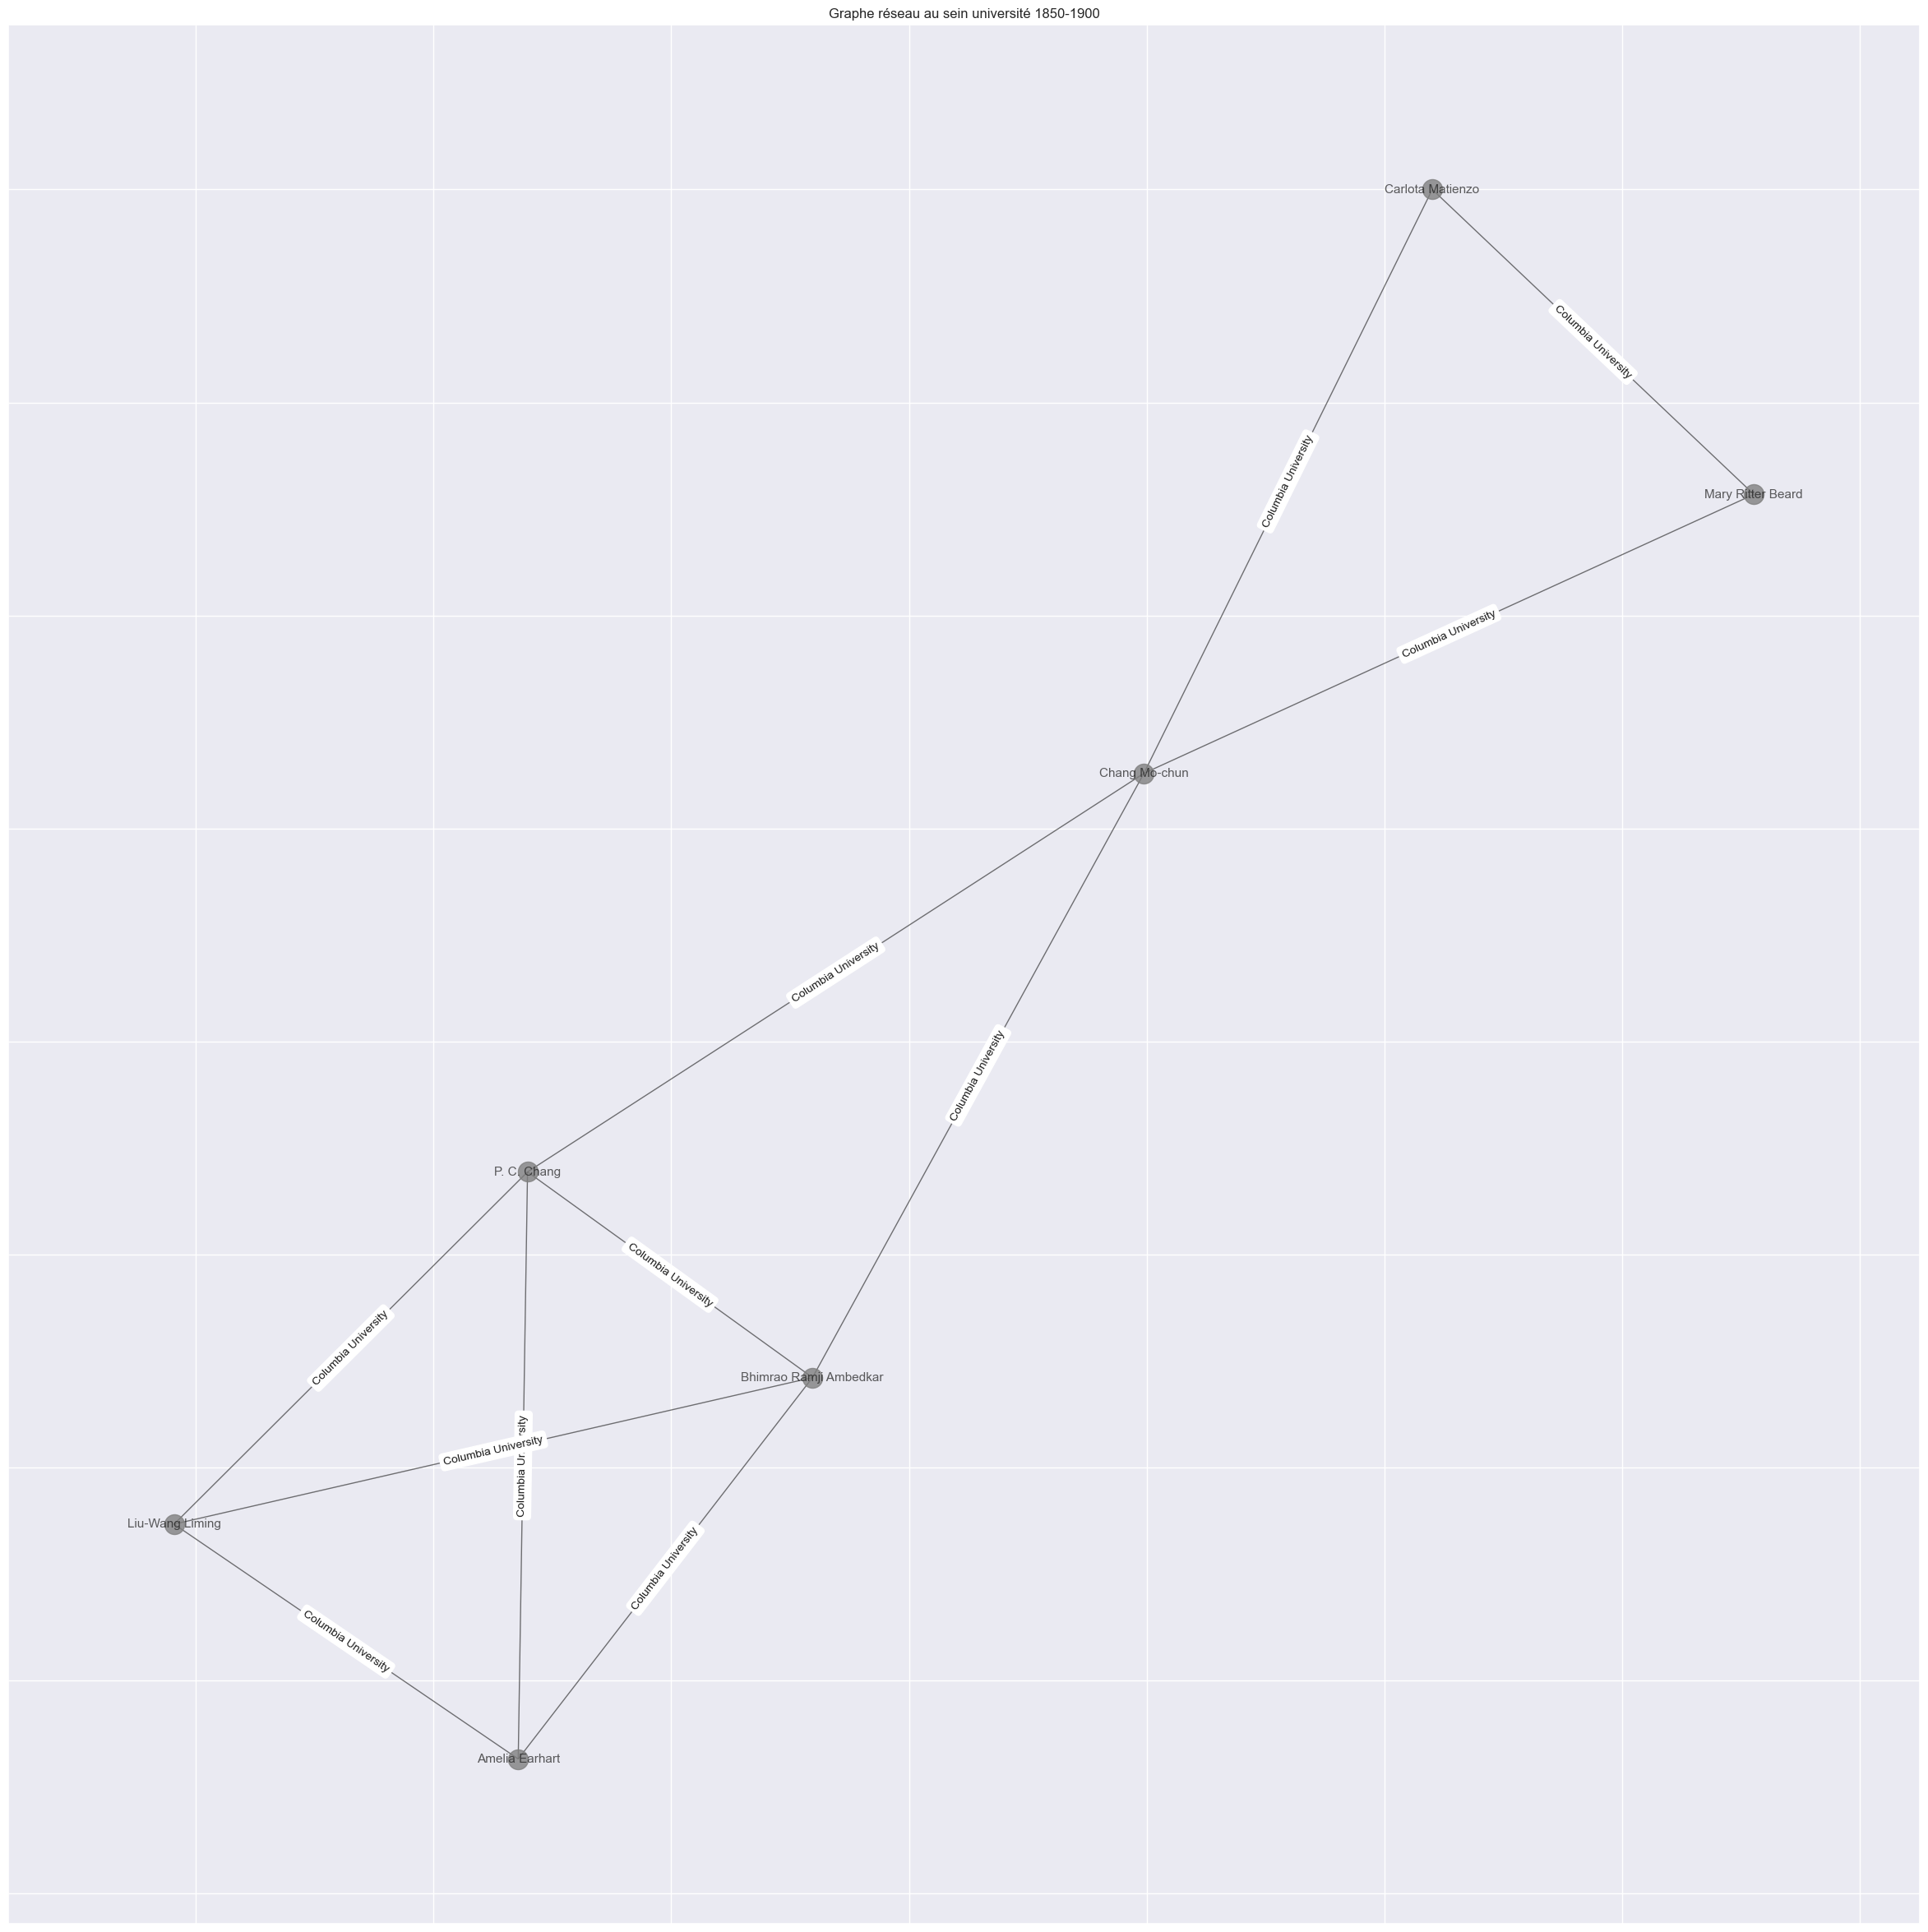

In [83]:
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
pos = nx.spring_layout(g, k=1)

labels = {e: u.get_edge_data(e[0], e[1])["organisation"] for e in u.edges()}

cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_color=cp, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=11)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)

plt.savefig('images/graphe_reseau_universite.jpg')
plt.title('Graphe réseau au sein université 1850-1900')
plt.show()

**ça fonctionne pas pour le 20ème siècle mais pour 1850-1900 oui**

## organisation relations entre université je ne sais pas comment le faire ?

Faudra regarder la médiane des relations 

In [137]:
pairs_o[:2]


[[{'fk_personne': 'http://www.wikidata.org/entity/Q119856937',
   'nom': 'ABilly S. Jones-Hennin',
   'annee_nais': 1942,
   'fk_uni': 'http://www.wikidata.org/entity/Q1068752',
   'universite': 'Howard University',
   'YBegin': 1959,
   'YEnd': 1969,
   'periode': '1900_1950'},
  {'fk_personne': 'http://www.wikidata.org/entity/Q119856937',
   'nom': 'ABilly S. Jones-Hennin',
   'annee_nais': 1942,
   'fk_uni': 'http://www.wikidata.org/entity/Q7934591',
   'universite': 'Virginia State University',
   'YBegin': 1959,
   'YEnd': 1969,
   'periode': '1900_1950'}],
 [{'fk_personne': 'http://www.wikidata.org/entity/Q4662358',
   'nom': 'Aaron Rhodes',
   'annee_nais': 1949,
   'fk_uni': 'http://www.wikidata.org/entity/Q1140775',
   'universite': 'Reed College',
   'YBegin': 1966,
   'YEnd': 1976,
   'periode': '1900_1950'},
  {'fk_personne': 'http://www.wikidata.org/entity/Q4662358',
   'nom': 'Aaron Rhodes',
   'annee_nais': 1949,
   'fk_uni': 'http://www.wikidata.org/entity/Q131252',
   